### Importando Bibliotecas

1 - Pré processamento

2 - EDA

3 - Matriz TD-IDF

4 - Undersample 

5 - Dendograma

6 - Kmenas (justificando decisão de grupos com base no dendodrama)

7 - Hierarquico

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
!pip install unidecode
import nltk
from nltk import word_tokenize
import string
import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importando Base de Dados

In [154]:
#load data from txt file with no head witch the data is splot by :::
trainData = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/train_data.txt', sep=':::', engine='python',header=None)
testData = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/test_data_solution.txt', sep=':::', engine='python',header=None)
#combing dataset's
data = trainData.append(testData)
#remove index
data = data.drop([0], axis=1)
#set dataframe head 
data.columns = ['name', 'genre','description']

### ETL

In [155]:
#removing whitespaces from the start and end of the colum "genre"
data['genre'] = data['genre'].str.strip()

In [156]:
print("before filtering genres: ",len(data))
filter_list = ['drama', 'comedy', 'horror', 'thriller', 'action', 'mystery', 'sci-fi', 'fantasy', 'western', 'romance', 'music']
data = data[data['genre'].isin(filter_list)]
print("after filtering genres: ",len(data))

before filtering genres:  108414
after filtering genres:  59781


Vamo ver se a gente vai usar isso, talvez tentar primeiro sem:

In [157]:
#creating a "super-genre" out of "horror", "thriller" and "mystery" 
data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')

#creating a "super-genre" out of "sci-fi" and "fantasy"
data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')

#reindex data
data = data.reset_index(drop=True)

<ipython-input-157-ec25735b02ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')
<ipython-input-157-ec25735b02ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')


In [158]:
#removendo possiveis valores nulos de descrição
data = data[data['description'].notna()]

### EDA

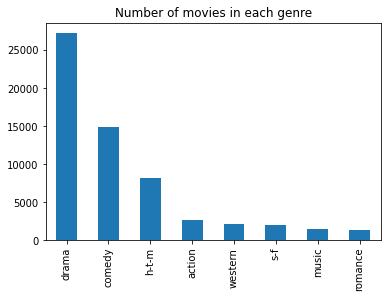

In [159]:
#ploting the number of movies in each genre
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

### Construção da Matriz TF-IDF

In [160]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
def criandoLinha(descrição):
    #capturando tokens da descrição
    tokens = word_tokenize(descrição)
    #normalizando para minúsculo
    tokens = [w.lower() for w in tokens]

    #removendo simbolos de pontuação
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

    #tratando caracteres especiais
    tokens = [unidecode.unidecode(w) for w in tokens]

    #selecionando apenas palavras
    words = [word for word in tokens if word.isalpha()]

    #removendo palavras com 3 ou menos caracteres
    words = [word for word in words if len(word) > 3]



    #removendo palavras vazias
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

     # Create n-grams


    #redução de palavras
    porter = PorterStemmer()
    stemmedWords = [porter.stem(word) for word in words] 

    n = 2
    ngrams = []
    for i in range(len(words)-n+1):
        ngram = " ".join(words[i:i+n])
        ngrams.append(ngram)

    #transformando lista de stemmedWords em uma string
    stringTerms = ' '.join(stemmedWords)



    return stringTerms

In [162]:
#criando a lista de strings de termos
listStringTerms = data['description'].apply(criandoLinha)

In [163]:
##construindo matriz TF-IDF
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(listStringTerms)
X

<59781x20988 sparse matrix of type '<class 'numpy.float64'>'
	with 2492125 stored elements in Compressed Sparse Row format>

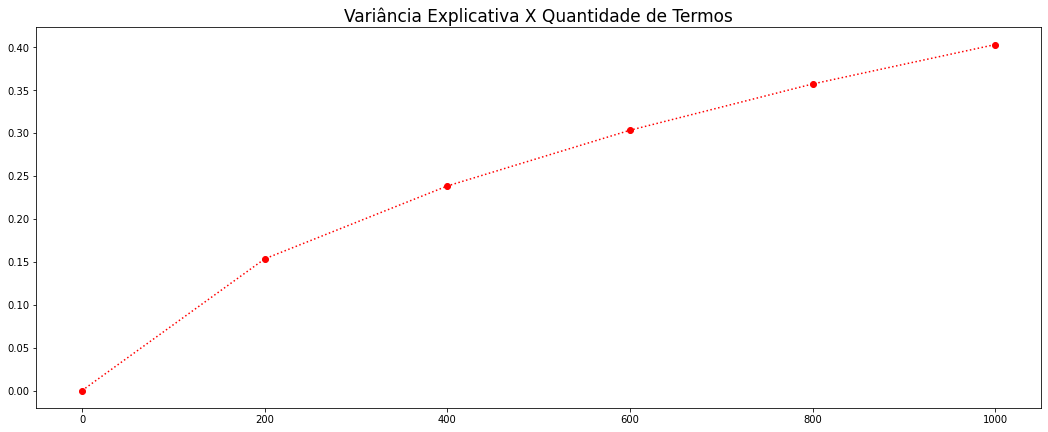

In [164]:
listVarianciaExplicativa = []

for n in range(0, 1200, 200):
    X_svd = TruncatedSVD(n_components=n)
    lsa = X_svd.fit(X)
    listVarianciaExplicativa.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(18, 7))
plt.title('Variância Explicativa X Quantidade de Termos', fontsize = 17);
plt.plot(range(0, 1200, 200), listVarianciaExplicativa, 'ro:')

In [165]:
svd = TruncatedSVD(n_components=1000, random_state=3)
X_svd = svd.fit_transform(X)

In [166]:
svd.explained_variance_ratio_.sum()

0.4030615082599081

### Agrupamentos

#### Funções Auxiliares

In [167]:
def reduzDadosProporcionalmente(tamanhoSample):
  totalMovies = data['genre'].value_counts()
  total = 0
  listPesos = [0,0,0,0,0,0,0,0]
  genreList = ['drama', 'comedy','h-t-m','action','s-f','western','romance','music']

  for i in totalMovies:
    total += i

  for i in range(0,8):
    listPesos[i] = data['genre'].value_counts()[genreList[i]]/total


  newQtdMoviesByGeng = []
  for i in range(0,8):
    newQtdMoviesByGeng.append(round(tamanhoSample*listPesos[i]))

  listNewDf = []
  for i in range(0,8):
    df = data[data['genre'] == genreList[i]]
    df = df.sample(newQtdMoviesByGeng[i])

    listNewDf.append(df)

  for i in range(1,len(listNewDf)):
    listNewDf[0] = listNewDf[0].append(listNewDf[i])

  newData = listNewDf[0]
  newData = newData.reset_index(drop=True)
  
  return newData


In [168]:
def genreByGroup(grupo, listTotalMovie, data):
  contList = [0,0,0,0,0,0,0,0]
  genreList = ['drama', 'comedy','h-t-m','action','s-f','western','romance','music']

  for row in grupo.index:
      genreGroup = data.loc[row]['genre']
      for i in range(0,len(genreList)):
        if genreList[i] == genreGroup:
          contList[i] += 1

  for i in range(0,8):
    contList[i] = contList[i]/listTotalMovie[genreList[i]]


  return genreList, contList

#### Dendograma

In [81]:
denData = reduzDadosProporcionalmente(5000)

#criando a lista de strings de termos
denListStringTerms = denData['description'].apply(criandoLinha)

##construindo matriz TF-IDF
denNectorizer = TfidfVectorizer(min_df = 5)
denX = denNectorizer.fit_transform(denListStringTerms)
denX

<5000x5451 sparse matrix of type '<class 'numpy.float64'>'
	with 190574 stored elements in Compressed Sparse Row format>

In [82]:
denSvd = TruncatedSVD(n_components=200, random_state=3)
denX_svd = denSvd.fit_transform(denX)

In [83]:
denSvd.explained_variance_ratio_.sum()

0.2429885810125099

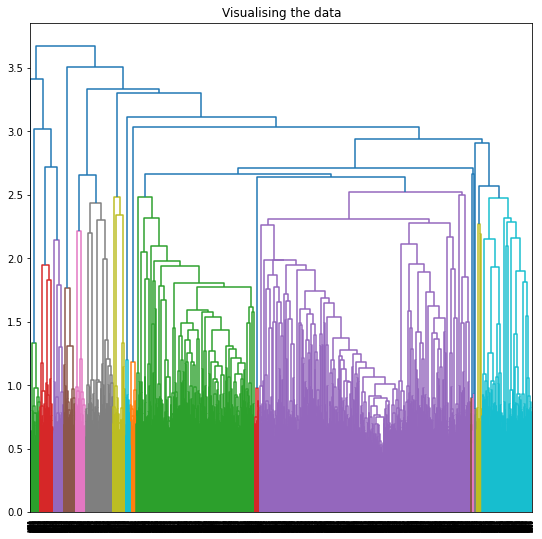

In [84]:
plt.figure(figsize =(9, 9))
plt.title('Visualising the data')
Dendrogram = hierarchy.dendrogram((hierarchy.linkage(denX_svd, method ='ward')))

#### K-MEANS

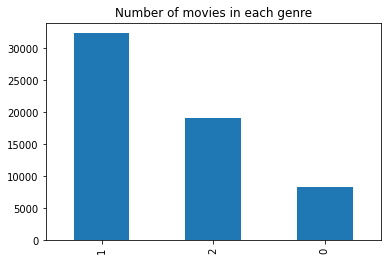

In [169]:
kmeans = KMeans(n_clusters=3, random_state=45).fit(X_svd)
y_kmeans = kmeans.predict(X_svd)

pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [170]:
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])

totalMovies = data['genre'].value_counts()
grupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
grupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
grupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]

drama      27225
comedy     14893
h-t-m       8226
action      2629
western     2064
s-f         1938
music       1462
romance     1344
Name: genre, dtype: int64

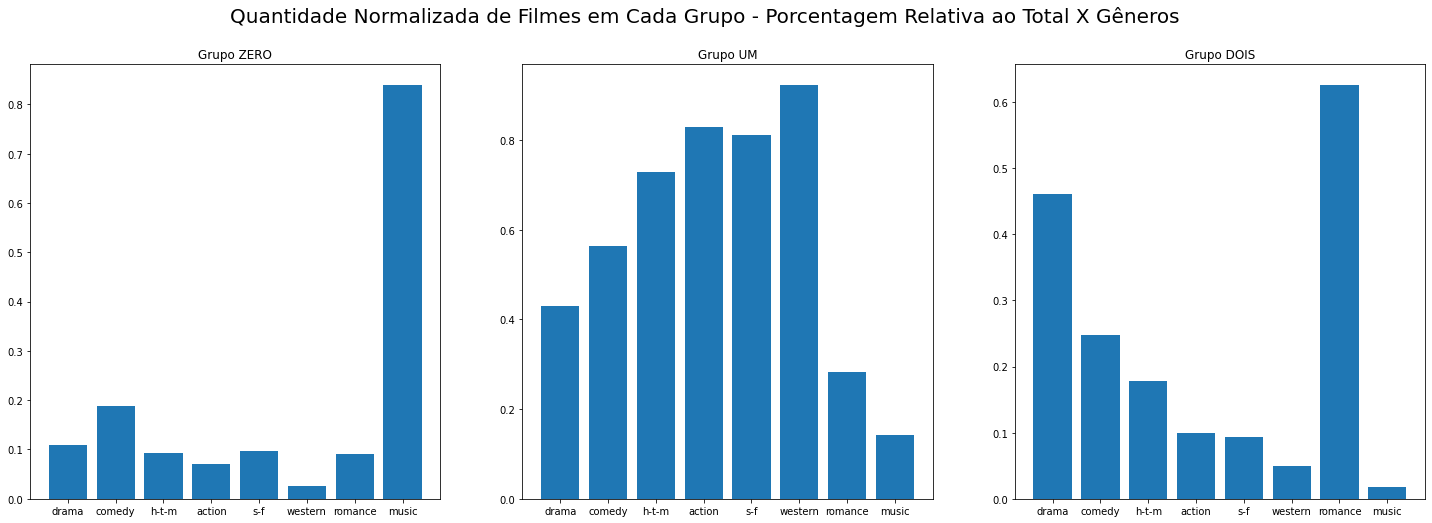

In [171]:
zeroX, zeroY = genreByGroup(grupoZero,totalMovies,data)
umX, umY = genreByGroup(grupoUm,totalMovies,data)
doisX, doisY = genreByGroup(grupoDois,totalMovies,data)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
fig.suptitle('Quantidade Normalizada de Filmes em Cada Grupo - Porcentagem Relativa ao Total X Gêneros', fontsize = 20)

ax1.bar(zeroX, zeroY)
ax1.set_title('Grupo ZERO')

ax2.bar(umX, umY)
ax2.set_title('Grupo UM')

ax3.bar(doisX, doisY)
ax3.set_title('Grupo DOIS')

totalMovies

Agora vamos agrupar novamente, porém com base nos filmes contidos no GRUPO_UM do agrupamento anterior

In [172]:
subData = data.loc[grupoUm.index.tolist()]
subX_svd = X_svd[subData.index]

subData = subData.reset_index(drop=True)

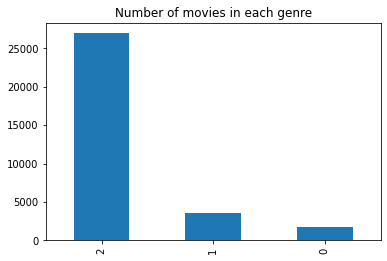

In [173]:
kmeans = KMeans(n_clusters=3, random_state=45).fit(subX_svd)
y_kmeans = kmeans.predict(subX_svd)

pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [174]:
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])

subTotalMovies = subData['genre'].value_counts()
subGrupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
subGrupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
subGrupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]

drama      11687
comedy      8410
h-t-m       5999
action      2179
western     1907
s-f         1571
romance      380
music        207
Name: genre, dtype: int64

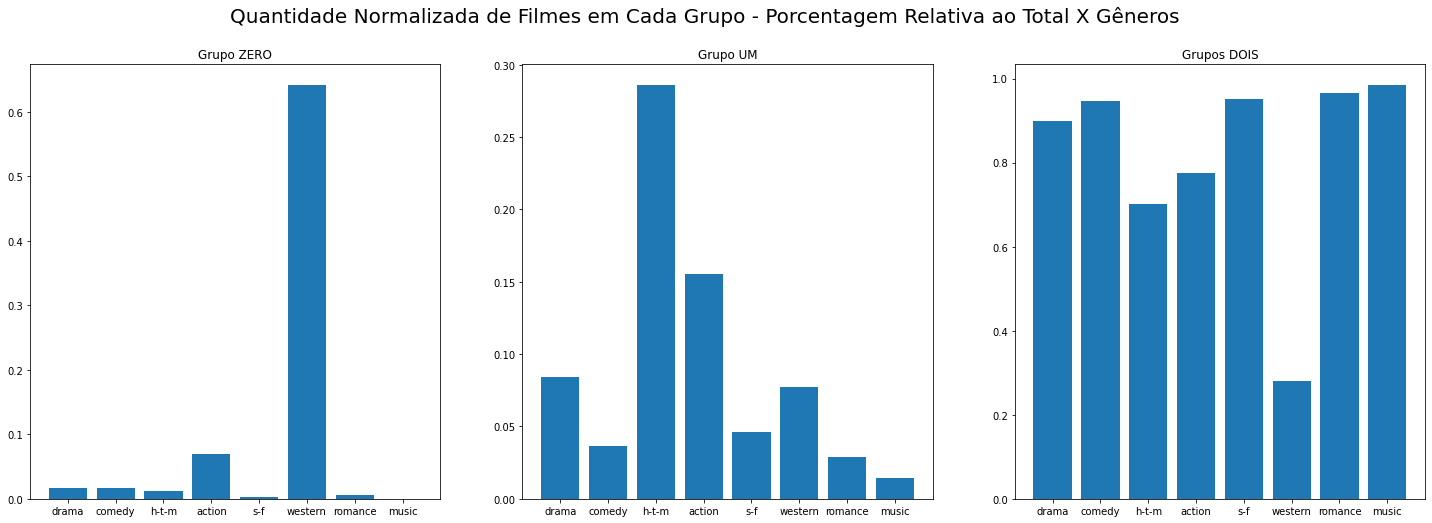

In [175]:
zeroX, zeroY = genreByGroup(subGrupoZero,subTotalMovies,subData)
umX, umY = genreByGroup(subGrupoUm,subTotalMovies,subData)
doisX, doisY = genreByGroup(subGrupoDois,subTotalMovies,subData)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
fig.suptitle('Quantidade Normalizada de Filmes em Cada Grupo - Porcentagem Relativa ao Total X Gêneros', fontsize = 20)

ax1.bar(zeroX, zeroY)
ax1.set_title('Grupo ZERO')

ax2.bar(umX, umY)
ax2.set_title('Grupo UM')

ax3.bar(doisX, doisY)
ax3.set_title('Grupos DOIS')

subTotalMovies

Aplicando a mesma lógica de divisão do dataSet porem agora para o subGrupo_DOIS

In [176]:
sub_subData = subData.loc[subGrupoDois.index.tolist()]
sub_subX_svd = X_svd[sub_subData.index]

sub_subData = sub_subData.reset_index(drop=True)

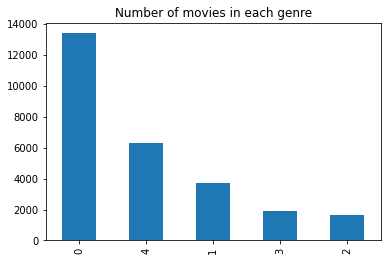

In [189]:
kmeans = KMeans(n_clusters=5, random_state=45).fit(sub_subX_svd)
y_kmeans = kmeans.predict(sub_subX_svd)

pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [190]:
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])

sub_subTotalMovies = sub_subData['genre'].value_counts()
sub_subGrupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
sub_subGrupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
sub_subGrupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]

sub_subGrupoTres = y_kmeans_df[y_kmeans_df['genre'] == 3]
sub_subGrupoQuatro = y_kmeans_df[y_kmeans_df['genre'] == 4]

drama      10498
comedy      7967
h-t-m       4205
action      1687
s-f         1495
western      535
romance      367
music        204
Name: genre, dtype: int64

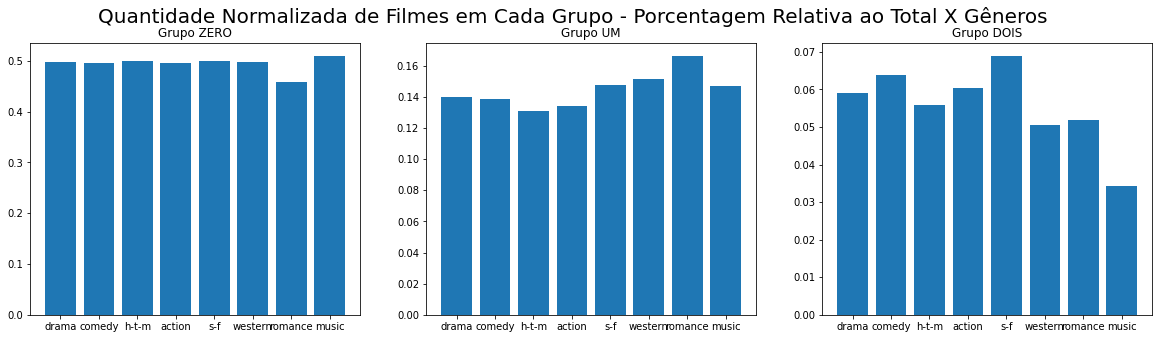

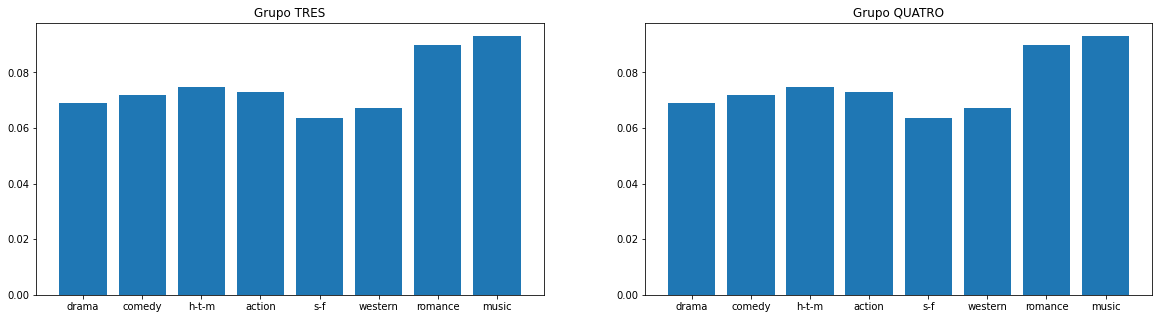

In [197]:
zeroX, zeroY = genreByGroup(sub_subGrupoZero,sub_subTotalMovies,sub_subData)
umX, umY = genreByGroup(sub_subGrupoUm,sub_subTotalMovies,sub_subData)
doisX, doisY = genreByGroup(sub_subGrupoDois,sub_subTotalMovies,sub_subData)
tresX, tresY = genreByGroup(sub_subGrupoTres,sub_subTotalMovies,sub_subData)
quatroX, quatroY = genreByGroup(sub_subGrupoQuatro,sub_subTotalMovies,sub_subData)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20.11,5))
fig.suptitle('Quantidade Normalizada de Filmes em Cada Grupo - Porcentagem Relativa ao Total X Gêneros', fontsize = 20)

ax1.bar(zeroX, zeroY)
ax1.set_title('Grupo ZERO')

ax2.bar(umX, umY)
ax2.set_title('Grupo UM')

ax3.bar(doisX, doisY)
ax3.set_title('Grupo DOIS')


fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20,5))
ax4.bar(tresX, tresY)
ax4.set_title('Grupo TRES')

ax5.bar(tresX, tresY)
ax5.set_title('Grupo QUATRO')

sub_subTotalMovies

Chegamos em um fim...

#### Agrupamento Hierárquico

In [139]:
data['genre'].value_counts(normalize=True)

drama      0.455412
comedy     0.249126
h-t-m      0.137602
action     0.043977
western    0.034526
s-f        0.032418
music      0.024456
romance    0.022482
Name: genre, dtype: float64

In [140]:
#definindo proporções arbitrariamente
weights ={'drama': 0.3, 'comedy': 0.3, 'h-t-m': 0.2, 'action': 1, 'western': 1, 'romance': 1, 'music': 1, 's-f': 1}
weights

{'drama': 0.3,
 'comedy': 0.3,
 'h-t-m': 0.2,
 'action': 1,
 'western': 1,
 'romance': 1,
 'music': 1,
 's-f': 1}

In [141]:
#ressample data to balance classes and reduce dataset size using weights
data_r = data.groupby('genre', group_keys=False).apply(lambda x: x.sample(frac=weights[x.name], random_state=3))

#reduce propocionally, the dataset 
data_r = data_r.sample(frac=0.5, random_state=3)
data_r

,name,genre,description
28474,Moment to Moment (1975),comedy,"An experimental, ludicrous, plotless, absurd,..."
48549,"""Will It Snow at Christmas?"" (2009)",romance,"Cha Kang Jin is the son of barmaid, Cha Chun ..."
28774,Skulduggery (1989),drama,Four lads decide to meet up and do a robbery ...
56759,Donavon Frankenreiter: The Abbey Road Session...,music,"Filmed in the famous Abbey Road studios, this..."
11615,Satan's Harvest (1970),action,When his uncle is killed in a horrible animal...
...,...,...,...
3106,Five Bold Women (1960),western,Marshal Kirk Reed is escorting five female pr...
51620,"""Despertar contigo"" (2016)",romance,Pablo Herminio loves being a bodyguard. When ...
30492,The Perfect Stranger (2005),drama,'THE PERFECT STRANGER' tells the story of Nik...
18228,Roadman (2010),h-t-m,"To his neighbours and workmates, Max Greif is..."


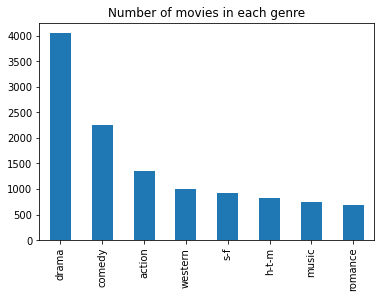

In [142]:
data_r['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

In [143]:
listStringTerms = data_r['description'].apply(criandoLinha)

In [144]:
##construindo matriz TF-IDF
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(listStringTerms)
X

<11859x8976 sparse matrix of type '<class 'numpy.float64'>'
	with 472356 stored elements in Compressed Sparse Row format>

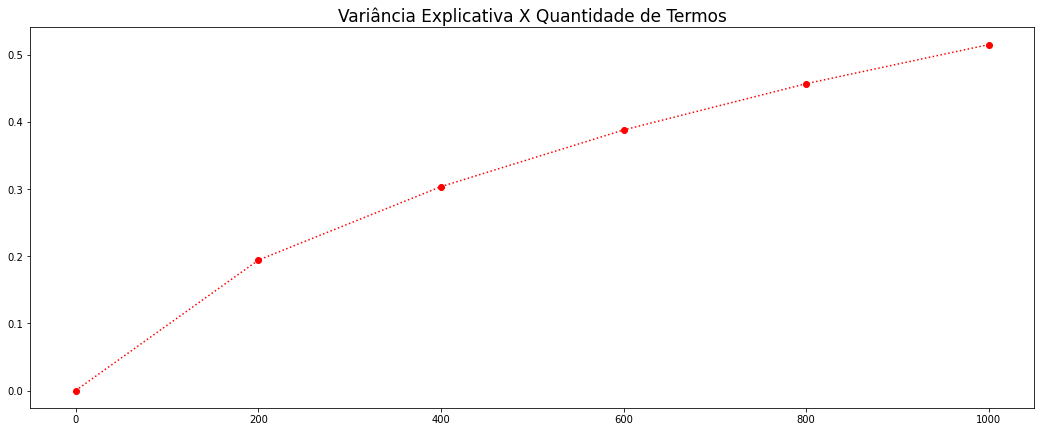

In [145]:
listVarianciaExplicativa = []

for n in range(0, 1200, 200):
    X_svd = TruncatedSVD(n_components=n)
    lsa = X_svd.fit(X)
    listVarianciaExplicativa.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(18, 7))
plt.title('Variância Explicativa X Quantidade de Termos', fontsize = 17);
plt.plot(range(0, 1200, 200), listVarianciaExplicativa, 'ro:')

In [120]:
svd = TruncatedSVD(n_components=200, random_state=3)
X_svd = svd.fit_transform(X)

Dendograma hierárquico, linkage "complete" com 6 grupos


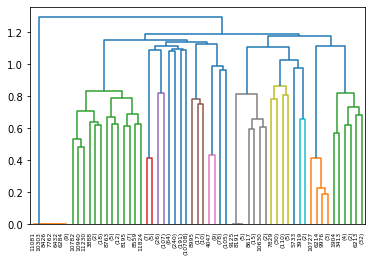

In [121]:
hierarquia_1 = hierarchy.linkage(X_svd, method='complete')
hierarchy.dendrogram(hierarquia_1,p=6,truncate_mode="level")
plt.show()

Dendograma hierárquico, linkage "complete" com 3 grupos


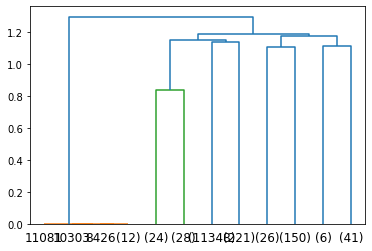

In [122]:
hierarquia_2 = hierarchy.linkage(X_svd, method='complete')
hierarchy.dendrogram(hierarquia_2,p=3,truncate_mode="level")
plt.show()

Dendograma hierárquico, linkage "ward" com 6 grupos



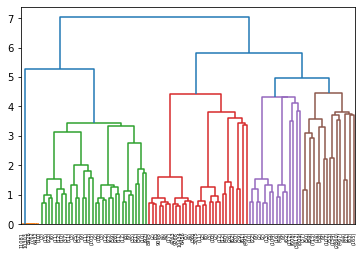

In [123]:
hierarquia_3 = hierarchy.linkage(X_svd, method='ward')
hierarchy.dendrogram(hierarquia_3,p=6,truncate_mode="level")
plt.show()

Dendograma hierárquico, linkage "ward" com 3 grupos

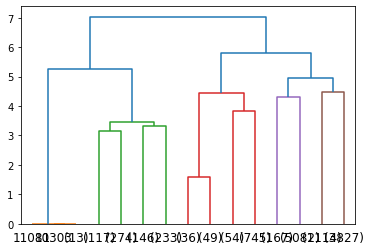

In [124]:
agrup_hie_complete = hierarchy.linkage(X_svd, method='ward')
hierarchy.dendrogram(agrup_hie_complete,p=3,truncate_mode="level")
plt.show()

Dendograma hierárquico, linkage "average" com 3 grupos


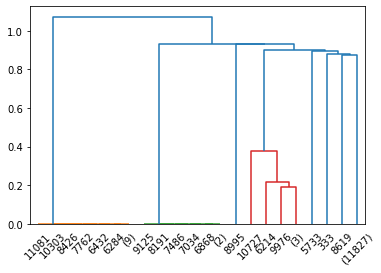

In [125]:
agrup_hie_complete = hierarchy.linkage(X_svd, method='average')
hierarchy.dendrogram(agrup_hie_complete,p=6,truncate_mode="level")
plt.show()

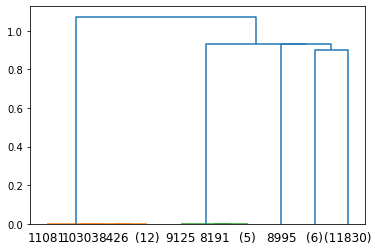

In [126]:
agrup_hie_complete = hierarchy.linkage(X_svd, method='average')
hierarchy.dendrogram(agrup_hie_complete,p=3,truncate_mode="level")
plt.show()

In [127]:
hierarquico_6 = AgglomerativeClustering(6, linkage = 'ward')
hierarquico_6.fit(X_svd);
print(np.unique(hierarquico_6.labels_, return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([ 884, 5249, 3827,   15,  770, 1114]))


In [128]:
totalMovies = data_r['genre'].value_counts()

In [129]:
df_hie = pd.DataFrame(hierarquico_6.labels_, columns=['genre'])
grupos_6 = [ df_hie[df_hie['genre'] == i] for i in range(0,6)]


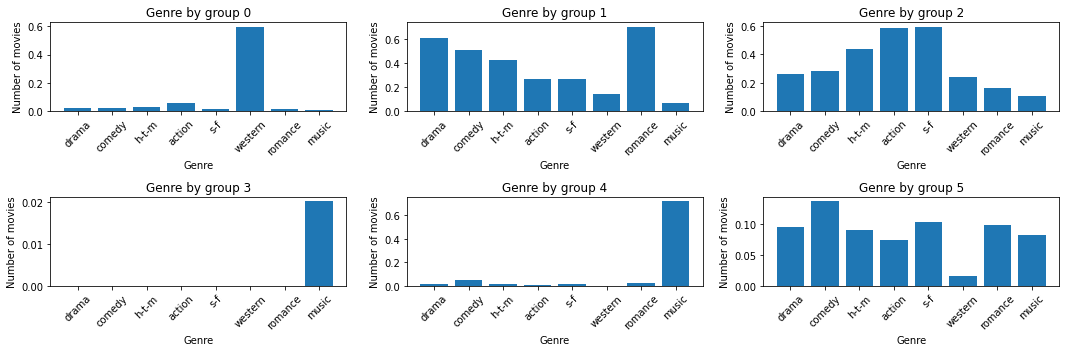

In [130]:
fig, ax = plt.subplots(2,3, figsize=(15,5))
for i in range(0,6):
      genreList,listCont = genreByGroup(grupos_6[i],totalMovies,data_r.reset_index())
      ax[i//3,i%3].bar(genreList,listCont)
      ax[i//3,i%3].set_title('Genre by group')
      ax[i//3,i%3].set_xlabel('Genre')
      ax[i//3,i%3].set_ylabel('Number of movies')
      ax[i//3,i%3].set_title('Genre by group ' + str(i))
      ax[i//3,i%3].set_xticklabels(genreList, rotation=45)
fig.tight_layout()
plt.show()


In [131]:
hierarquico = AgglomerativeClustering(3, linkage = 'ward')
hierarquico.fit(X_svd);
print(np.unique(hierarquico.labels_, return_counts=True))

(array([0, 1, 2]), array([  785, 10190,   884]))


In [132]:
df_hie = pd.DataFrame(hierarquico.labels_, columns=['genre'])
grupos = [ df_hie[df_hie['genre'] == i] for i in range(0,6)]

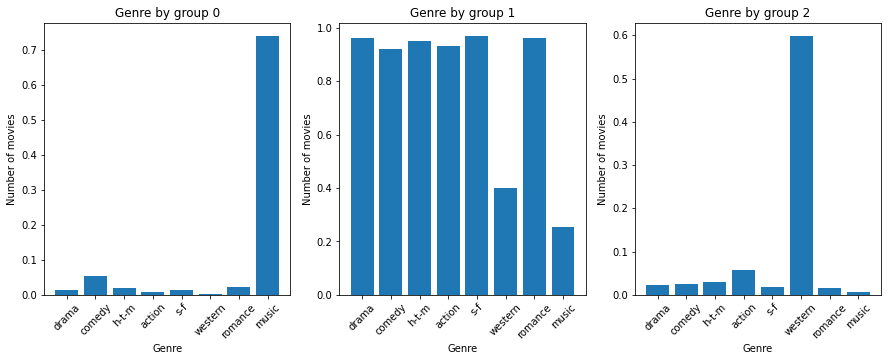

In [133]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(0,3):
      genreList,listCont = genreByGroup(grupos[i],totalMovies,data_r.reset_index())
      ax[i].bar(genreList,listCont)
      ax[i].set_title('Genre by group')
      ax[i].set_xlabel('Genre')
      ax[i].set_ylabel('Number of movies')
      ax[i].set_title('Genre by group ' + str(i))
      ax[i].set_xticklabels(genreList, rotation=45)

plt.show()


Ao analisar os dendogramas feitos para os grupos por aglomeramento hierárquico com várias abordagens de linkage, nota-se que não há uma divisão clara de muitos grupos. O que ocorre é que, há um grupo majoritário que distoa de outros dados e, dentre esses outros, possivelmente se divedem em dois grupos melhor separados.
